In [1]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mesh_grid = np.meshgrid(np.arange(0, 129, 8), np.arange(0, 129, 8))

In [7]:
coors = np.concatenate([mesh_grid[0][..., np.newaxis], mesh_grid[1][..., np.newaxis]], axis=2)

In [8]:
coors = coors.reshape(-1, 2)

In [10]:
points = coors

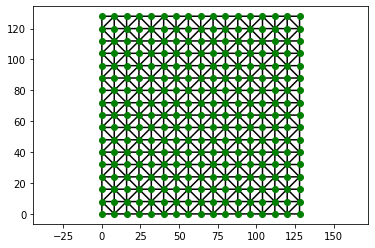

In [12]:
tris = Delaunay(coors)
plt.triplot(points[:, 0], points[:, 1], tris.simplices.copy(), c='black')
plt.plot(points[:, 0], points[:, 1], 'o', c='green')
plt.axis('equal')
plt.show()

In [15]:
tris.simplices.shape

(512, 3)

In [1]:
from utils.solve_DLT import *
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

/home/wyq/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
mesh_flow = torch.tensor([(0, 0), (0, 0), (0, 0), (0, 0), (-100, -100), (0, 0), (0, 0), (0, 0), (0, 0)], dtype=torch.float, device=torch.device("cpu")).permute(1, 0).reshape(2, 3, 3).unsqueeze(0)
mesh_flow = mesh_flow_upsampling(mesh_flow, (3, 3), (9, 9), (1280, 1280), 1, torch.device("cpu"))
# b, c = solve_mesh_flow_DLT_triangle(mesh_flow, torch.device("cpu"), (160, 160), (1280, 1280))

In [25]:
mesh_flow

tensor([[[[   0.0000,    5.1892,   13.3953,   28.3279,   64.0000,   71.3669,
             81.9649,   98.5169,  128.0000],
          [   0.0000,    6.6977,   18.8852,   48.0000,  130.9719,   58.9474,
             69.0337,   87.0000,  128.0000],
          [   0.0000,    9.4426,   32.0000,  157.0909,  -64.3208,   39.5506,
             46.0000,   60.7180,  128.0000],
          [   0.0000,   16.0000,  104.7273, -123.4286,  -24.5048,    5.0000,
             -6.5641,  -59.4284,  127.9999],
          [   0.0000,   24.1099,  -46.1955,  -31.8617,  -36.0000,  -17.1478,
            -82.4460,  237.8335,  128.0000],
          [   0.0000,   -5.0526,  -12.9438,  -27.0000,  -24.5048,   58.9474,
             90.2446,  112.0000,  128.0000],
          [   0.0000,   -6.4719,  -18.0000,  -44.3077,  -64.3209,   71.3669,
             96.0000,  114.1164,  128.0000],
          [   0.0000,   -9.0000,  -29.5385, -123.4287,  130.9717,   80.0000,
            100.2328,  115.7383,  128.0000],
          [   0.0000,  -

(9, 9, 2)


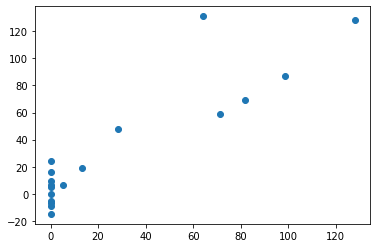

In [24]:
coors = mesh_flow.squeeze(0).permute(1, 2, 0).numpy()
print(coors.shape)
plt.figure()
plt.scatter(coors[:, 0],coors[:, 1])

In [11]:
print(origin_mesh_grid.shape)
print(mesh_flow.shape)

torch.Size([1, 2, 9, 9])
torch.Size([1, 2, 9, 9])


In [14]:
image_size = (1280, 1280)
patch_size = (160, 160)
device = torch.device("cpu")
from scipy.spatial import Delaunay
batch_size = mesh_flow.shape[0]
mesh_grid_X, mesh_grid_Y = torch.meshgrid(torch.arange(start=0, end=image_size[0] + 1, step=patch_size[0], dtype=torch.float, device=device),
    torch.arange(start=0, end=image_size[1] + 1, step=patch_size[1], dtype=torch.float, device=device,),
    indexing="ij",
)
mesh_grid = torch.cat([mesh_grid_X.unsqueeze(0), mesh_grid_Y.unsqueeze(0)], dim=0)
mesh_grid_flat = mesh_grid.permute(1, 2, 0).reshape(-1, 2)
tris = Delaunay(mesh_grid_flat.cpu().numpy())
tris_samples_indices = torch.from_numpy(tris.simplices).type(torch.int64)
origin_tris_samples = mesh_grid_flat[tris_samples_indices].unsqueeze(0).expand(batch_size, -1, -1, -1)
origin_mesh_grid = torch.cat([mesh_grid_X.unsqueeze(0), mesh_grid_Y.unsqueeze(0)], dim=0).unsqueeze(0).expand(batch_size, -1, -1, -1)
warped_mesh_grid = (origin_mesh_grid + mesh_flow).permute(0, 2, 3, 1).reshape(batch_size, -1, 2)

In [18]:
warped_tris_samples = warped_mesh_grid[:, tris_samples_indices, :]
solved_matrices = solve_affine_DLT(warped_tris_samples.reshape(-1, 3, 2), origin_tris_samples.reshape(-1, 3, 2), device=device)

points_grid = torch.meshgrid(torch.arange(start=0.5, end=image_size[0], step=1, dtype=torch.float, device=device), \
    torch.arange(start=0.5, end=image_size[1], step=1, dtype=torch.float, device=device), indexing='xy')
points_grid = torch.cat([points_grid[0].unsqueeze(2), points_grid[1].unsqueeze(2)], dim=2).unsqueeze(0).expand(origin_tris_samples.reshape(-1, 3, 2).shape[0], -1, -1, -1)

def GetCross(point1, point2, points_grid, mesh_grid):
    cross_product = (mesh_grid[:, 0:1, point2:point2 + 1, 0] - mesh_grid[:, 0:1, point1:point1 + 1, 0]) * (points_grid[:, :, :, 1] - mesh_grid[:, 0:1, point1:point1 + 1, 1]) - \
            (points_grid[:, :, :, 0] - mesh_grid[:, 0:1, point1:point1 + 1, 0]) * (mesh_grid[:, 0:1, point2:point2 + 1, 1] - mesh_grid[:, 0:1, point1:point1 + 1, 1])
    return cross_product

warped_tris_samples = warped_tris_samples.reshape(-1, 1, 3, 2)
cross12 = GetCross(0, 1, points_grid, warped_tris_samples)
cross23 = GetCross(1, 2, points_grid, warped_tris_samples)
cross31 = GetCross(2, 0, points_grid, warped_tris_samples)
points_grid_mask = torch.bitwise_and((cross12 * cross23) >= 0, (cross23 * cross31) >= 0,).float()
# For Test
print(points_grid_mask.shape)
mask_value = (torch.arange(0, 128, 1, device=device) * 2).unsqueeze(1).unsqueeze(2)
tris_map = (mask_value * points_grid_mask).sum(dim=0)
im = transforms.ToPILImage()(tris_map)
im.save("tris_map.jpg")

torch.Size([128, 1280, 1280])


In [28]:
a = torch.arange(12).reshape(2, 3, 2)

In [29]:
a

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]]])

In [30]:
torch.flip(a, dims=(2,))

tensor([[[ 1,  0],
         [ 3,  2],
         [ 5,  4]],

        [[ 7,  6],
         [ 9,  8],
         [11, 10]]])

In [8]:
warped_mesh_grid.shape

torch.Size([1, 81, 2])

(81, 2)


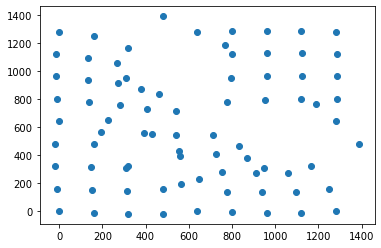

In [15]:
coors = warped_mesh_grid.squeeze(0).numpy()
print(coors.shape)
plt.figure()
plt.scatter(coors[:, 1],coors[:, 0])

In [3]:
def solve_mesh_flow_DLT_triangle(mesh_flow: torch.Tensor, device: torch.device, patch_size: Tuple[int], image_size: Tuple[int]) -> Tuple[torch.Tensor]:
    # TODO: In future development, Delaunay mesh calculation should be completed outside the function
    from scipy.spatial import Delaunay
    batch_size = mesh_flow.shape[0]
    mesh_grid_X, mesh_grid_Y = torch.meshgrid(torch.arange(start=0, end=image_size[0] + 1, step=patch_size[0], dtype=torch.float, device=device),
        torch.arange(start=0, end=image_size[1] + 1, step=patch_size[1], dtype=torch.float, device=device,),
        indexing="xy",
    )
    mesh_grid = torch.cat([mesh_grid_X.unsqueeze(0), mesh_grid_Y.unsqueeze(0)], dim=0)
    mesh_grid_flat = mesh_grid.permute(1, 2, 0).reshape(-1, 2)
    tris = Delaunay(mesh_grid_flat.cpu().numpy())
    tris_samples_indices = torch.from_numpy(tris.simplices).type(torch.int64)
    origin_tris_samples = mesh_grid_flat[tris_samples_indices].unsqueeze(0).expand(batch_size, -1, -1, -1)
    origin_mesh_grid = torch.cat([mesh_grid_X.unsqueeze(0), mesh_grid_Y.unsqueeze(0)], dim=0).unsqueeze(0).expand(batch_size, -1, -1, -1)
    warped_mesh_grid = (origin_mesh_grid + mesh_flow).permute(0, 2, 3, 1).reshape(batch_size, -1, 2)
    warped_tris_samples = warped_mesh_grid[:, tris_samples_indices, :]
    solved_matrices = solve_affine_DLT(warped_tris_samples.reshape(-1, 3, 2), origin_tris_samples.reshape(-1, 3, 2), device=device)

    points_grid = torch.meshgrid(torch.arange(start=0.5, end=image_size[0], step=1, dtype=torch.float, device=device), \
        torch.arange(start=0.5, end=image_size[1], step=1, dtype=torch.float, device=device), indexing='xy')
    points_grid = torch.cat([points_grid[0].unsqueeze(2), points_grid[1].unsqueeze(2)], dim=2).unsqueeze(0).expand(origin_tris_samples.reshape(-1, 3, 2).shape[0], -1, -1, -1)

    def GetCross(point1, point2, points_grid, mesh_grid):
        cross_product = (mesh_grid[:, 0:1, point2:point2 + 1, 0] - mesh_grid[:, 0:1, point1:point1 + 1, 0]) * (points_grid[:, :, :, 1] - mesh_grid[:, 0:1, point1:point1 + 1, 1]) - \
                (points_grid[:, :, :, 0] - mesh_grid[:, 0:1, point1:point1 + 1, 0]) * (mesh_grid[:, 0:1, point2:point2 + 1, 1] - mesh_grid[:, 0:1, point1:point1 + 1, 1])
        return cross_product

    warped_tris_samples = warped_tris_samples.reshape(-1, 1, 3, 2)
    cross12 = GetCross(0, 1, points_grid, warped_tris_samples)
    cross23 = GetCross(1, 2, points_grid, warped_tris_samples)
    cross31 = GetCross(2, 0, points_grid, warped_tris_samples)
    points_grid_mask = torch.bitwise_and((cross12 * cross23) >= 0, (cross23 * cross31) >= 0,).float()
    # For Test
    print(points_grid_mask.shape)
    mask_value = (torch.arange(0, 128, 1, device=device) * 2).unsqueeze(1).unsqueeze(2)
    tris_map = (mask_value * points_grid_mask).sum(dim=0)
    im = transforms.ToPILImage()(tris_map)
    im.save("tris_map.jpg")
    points_grid = points_grid.reshape(-1, image_size[0] * image_size[1], 2)
    # print(solved_matrices.shape, points_grid.shape)
    warped_points_grid = torchgeometry.core.transform_points(solved_matrices, points_grid).reshape(batch_size, -1, image_size[0], image_size[1], 2)
    points_grid_mask = points_grid_mask.reshape(batch_size, -1, image_size[0], image_size[1], 1)
    warped_points = (warped_points_grid * points_grid_mask).sum(dim=1) / points_grid_mask.sum(dim=1)
    # torch.save(points_grid_mask.sum(dim=1), "test.pt")
    warped_points = warped_points.permute(0, 3, 1, 2)

    return warped_points, solved_matrices


In [16]:
import torch
import torchgeometry
import torch.nn as nn
from typing import *
from torchgeometry.core.transformations import transform_points


def mesh_flow_upsampling(mesh_flow_tensor:torch.Tensor, mesh_grid_size:Tuple[int], upsample_grid_size:Tuple[int], img_size:Tuple[int], batch_size:int, device:torch.device):
    """upsample mesh flow result from mesh grid size to upsampling grid size

    Args:
      mesh_flow_tensor: tensor result of mesh flow. Data format: (N, 2, mesh_grid_size[0], mesh_grid_size[1])
      mesh_grid_size: mesh grid of low resolution
      upsample_grid_size: mesh grid of high resolutin
      img_size: size of input image
      batch_size: batch size of data
      device: torch device (cpu or gpu)
    
    Returns:
      upsampled mesh flow tensor with shape: (N, 2, upsample_grid_size[0], upsample_grid_size[1])
    """
    # step 1: unfold mesh flow tensor
    unfold = nn.Unfold(kernel_size=(2, 2))
    # caution: unfold tensor data format is [batch_size, c * kernel_h * kernel_w, patches]
    mesh_flow = unfold(mesh_flow_tensor).permute(0, 2, 1)
    mesh_flow = mesh_flow.reshape(mesh_flow.shape[0] * mesh_flow.shape[1], -1)
    mesh_flow = mesh_flow.reshape(-1, 2, 4).permute(0, 2, 1)
    # step 2: get mesh grid of mesh_grid size
    y_t = torch.matmul(torch.ones(mesh_grid_size[0], 1, dtype=torch.float, device=device), \
      torch.linspace(0, img_size[1], mesh_grid_size[1], dtype=torch.float, device=device).unsqueeze(0)).unsqueeze(2)
    x_t = torch.matmul(torch.linspace(0, img_size[0], mesh_grid_size[0], dtype=torch.float, device=device).unsqueeze(1), \
      torch.ones(1, mesh_grid_size[1], dtype=torch.float, device=device)).unsqueeze(2)
    # grid_sparse shape: [batch_size, 2, mesh_grid_size[0], mesh_grid_size[1]]
    grid_sparse = torch.cat([y_t, x_t], dim=2).permute(2, 0, 1).unsqueeze(0).expand(batch_size, -1, -1, -1)
    # step 3: unfold sparse grid
    # unfolded grid sparse shape: [batch_size, 2 * 2 * 2, (mesh_grid_size[0] - 1) * (mesh_grid_size[1] - 1)]
    grid_sparse_unfold = unfold(grid_sparse).permute(0, 2, 1)
    # unfolded grid sparse shape: [batch_size * (mesh_grid_size[0] - 1) * (mesh_grid_size[1] - 1), 2 * 2 * 2]
    grid_sparse_unfold = grid_sparse_unfold.reshape(grid_sparse_unfold.shape[0] * grid_sparse_unfold.shape[1], -1)
    # unfolded grid sparse shape: [batch_size * (mesh_grid_size[0] - 1) * (mesh_grid_size[1] - 1), 4, 2]
    grid_sparse_unfold = grid_sparse_unfold.reshape(-1, 2, 4).permute(0, 2, 1)
    # step 4: use original mesh grid and mesh flow to calculate mesh upsampling homography matrices
    solved_matrices = torchgeometry.get_perspective_transform(grid_sparse_unfold, grid_sparse_unfold + mesh_flow)
    # print(grid_sparse_unfold[1], "\n", (grid_sparse_unfold + mesh_flow)[1])

    # Whether Scaling?
    # patch_width = img_size[1] / (mesh_grid_size[1] - 1)
    # patch_height = img_size[0] / (mesh_grid_size[0] - 1)
    # solved_matrices_scaled = H_scale(solved_matrices, patch_width=patch_width, patch_height=patch_height, batch_size=batch_size)

    # step 5: get dense grid of upsample_grid_size
    y_t = torch.matmul(torch.ones(upsample_grid_size[0], 1, dtype=torch.float, device=device), \
      torch.linspace(0, img_size[1], upsample_grid_size[1], dtype=torch.float, device=device).unsqueeze(0)).unsqueeze(2)
    x_t = torch.matmul(torch.linspace(0, img_size[0], upsample_grid_size[0], dtype=torch.float, device=device).unsqueeze(1), \
      torch.ones(1, upsample_grid_size[1], dtype=torch.float, device=device)).unsqueeze(2)
    # grid shape: [batch_size, 2, upsample_grid_size[0], upsample_grid_size[1]]
    grid_dense = torch.cat([y_t, x_t], dim=2).permute(2, 0, 1).unsqueeze(0).expand(batch_size, -1, -1, -1)
    # step 6: unfold dense grid
    unfold_kernel_size = ((upsample_grid_size[0] - 1) // (mesh_grid_size[0] - 1) + 1, (upsample_grid_size[1] - 1) // (mesh_grid_size[1] - 1) + 1)
    unfold_stride = ((upsample_grid_size[0] - 1) // (mesh_grid_size[0] - 1), (upsample_grid_size[1] - 1) // (mesh_grid_size[1] - 1))
    unfold2 = nn.Unfold(kernel_size=unfold_kernel_size, stride=unfold_stride)
    # unfold_grid_dense (direct result) shape: [batch_size, 2 * unfold_kernel_size[0]*[1], patches]
    unfold_grid_dense = unfold2(grid_dense).permute(0, 2, 1).reshape(solved_matrices.shape[0], -1)
    unfold_grid_dense = unfold_grid_dense.reshape(-1, 2, unfold_kernel_size[0] * unfold_kernel_size[1]).permute(0, 2, 1)
    # step 7: transform points in unfolded dense grid using homography matrices solved from sparse mesh
    warped_unfold_grid_dense = transform_points(solved_matrices, unfold_grid_dense)
    # print(unfold_grid_dense[1])
    # print(warped_unfold_grid_dense[1])
    # print((warped_unfold_grid_dense[1] - unfold_grid_dense[1]))
    warped_unfold_grid_dense = warped_unfold_grid_dense.reshape(batch_size, -1, unfold_kernel_size[0], unfold_kernel_size[1], 2)
    warped_unfold_grid_dense = warped_unfold_grid_dense.permute(0, 4, 2, 3, 1).reshape(batch_size, 2 * unfold_kernel_size[0] * unfold_kernel_size[1], -1)
    
    # Caution: fold is not the inverse operation of unfold. It will sum the values of overlapped region
    # step 8: fold back transform points to mesh grid
    fold = torch.nn.Fold(output_size = (upsample_grid_size[0], upsample_grid_size[1]), kernel_size=unfold_kernel_size, stride=unfold_stride)
    warped_grid_dense = fold(warped_unfold_grid_dense)
    X_border = torch.arange(start=0, end=upsample_grid_size[0] - 1, step=unfold_kernel_size[0] - 1, dtype=torch.long)[1:]
    Y_border = torch.arange(start=0, end=upsample_grid_size[1] - 1, step=unfold_kernel_size[1] - 1, dtype=torch.long)[1:]
    X1, Y1 = torch.meshgrid(torch.arange(upsample_grid_size[0], dtype=torch.long), Y_border, indexing="ij")
    X2, Y2 = torch.meshgrid(X_border, torch.arange(upsample_grid_size[1], dtype=torch.long), indexing="ij")
    warped_grid_dense[:, :, X1, Y1] /= 2
    warped_grid_dense[:, :, X2, Y2] /= 2

    # step 9: subtract origin dense mesh grid from transformed mesh grid to obtain upsampled mesh flow
    upsample_mesh_flow = warped_grid_dense - grid_dense + grid_dense
    out = upsample_mesh_flow

    return out

In [38]:
mesh_grid_size = (3, 3)
img_size = (128, 128)
y_t = torch.matmul(torch.ones(mesh_grid_size[0], 1, dtype=torch.float, device=device), \
      torch.linspace(0, img_size[1], mesh_grid_size[1], dtype=torch.float, device=device).unsqueeze(0)).unsqueeze(2)
x_t = torch.matmul(torch.linspace(0, img_size[0], mesh_grid_size[0], dtype=torch.float, device=device).unsqueeze(1), \
      torch.ones(1, mesh_grid_size[1], dtype=torch.float, device=device)).unsqueeze(2)
    # grid_sparse shape: [batch_size, 2, mesh_grid_size[0], mesh_grid_size[1]]
grid_sparse = torch.cat([y_t, x_t], dim=2)

In [41]:
grid_sparse[:, :, 0]

tensor([[  0.,  64., 128.],
        [  0.,  64., 128.],
        [  0.,  64., 128.]])

In [34]:
grid_sparse[:, :, 0, 1]

tensor([[64.,  0.]])

In [37]:
torch.meshgrid(torch.linspace(0, img_size[0], mesh_grid_size[0]), torch.linspace(0, img_size[1], mesh_grid_size[1]), indexing='xy')

(tensor([[  0.,  64., 128.],
         [  0.,  64., 128.],
         [  0.,  64., 128.]]),
 tensor([[  0.,   0.,   0.],
         [ 64.,  64.,  64.],
         [128., 128., 128.]]))